# Multi-Classification Machine Learning for Malware Analysis
## 9 Types of Malware in this dataset:
    1. Ramnit         - RAT
    2. Lollipop       - Adware
    3. Kelihos_ver3   - RAT
    4. Vundo          - Adware
    5. Simda          - Botnet
    6. Tracur         - Malicious Browser Plugin
    7. Kelihos_ver1   - RAT
    8. Obfuscator.ACY - Obfuscates other malware/information
    9. Gatak          - RAT


## Game Plan:
    -Extract the number of instructions from each of the malware samples
    
    -Put that data into a data structure along with it's Class
    
    -I'll divide the samples by family and create 9 models, one for each family
    
    -I'll train each of these 9 models by feeding them the dataset
    
    -I will then run over the training set

## Questions:
    -The samples provided are certain families, will (Do you think) other types of adware be attributed towards      Lollipop, even though that model is trained on only on Lollipop samples?
    
    -Is this scope (9 malware families) good for a FYP?
    
    -Is accuracy critical here? I know a final year project doesn't have to be successful per se, what if I               can't get this working (very?) accurately?
            -Perceptotron (80-90%)
            
    
    -To demonstrate the efficacy of this model, is the "test" dataset provided on the website okay, or should I           acquire a sample of these malwares (from MalwareBazaar etc) and process them into the relevant formats           to demonstrate this?
    
    -The .asm files in this dataset include function calls etc, I presume this is required for the technique to          work, as purely ASM instructions maybe to abstract
        -Should I train on the .asm file outputted by IDA, raw Hex (.bytes file) or both?
        -What is the best form to provide this to the AI (Will Raw Files work?)
        -I want a way to feed each model all of the data for a given family, not sure how to do this effectively?

In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install jupyterthemes

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Imports

In [2]:
import os
import csv
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
from torch.autograd import Variable

# Pre-Processing and classifying the full Dataset

In [3]:
###PREPROCESSING THE DATA
##This is really ineffecient but I don't know a better way to do it right now and it should only need to be done once to process the data appropriately

#Read CSV In
#Convert to Pandas Dataframe
#Iterate over every file in the dataset-subset directory
#Every file in that directory will be in this CSV, It's name is looked up in the ID column and it is renamed to the class 

filenames = pd.read_csv("/home/eddy/machine-learning/data/trainLabels.csv")

# This builds a list of every file in this directory that matches this wildcard search
completePreRefineFileList = glob.glob("/home/eddy/machine-learning/data/dataset-subset/*.asm") 
# Making a list to count the occurences of each class to get a better indication of what my subset looks like in relation to the full dataset
eachClassOccurences = []

#iterate over every file in my training subset to create filenames list
for x in completePreRefineFileList: 
    
    #trim off the leading and trailing stuff that's not needed, leaving only the file name itself
    y = x.replace("/home/eddy/machine-learning/data/dataset-subset/","") 
    y = y.replace(".asm","")
    
    
    #iterate over every index in the DF except the header
    for i in range(1, filenames.index.stop): 
        #if the ID matches the file
        if(filenames.loc[i,"Id"] == y):
            #if the ID matches the file, access the class of that file
            print("File " + y + " is type " + str(filenames.loc[i,"Class"]))
            
            #add the class to the list created earlier to feed out snapshot of how our subset looks in comparison to the full dataset
            eachClassOccurences.append(filenames.loc[i,"Class"])
            
            
            

# From here, I can append the file name with it's type to allow for easier classification and assigning it to a given model

In [4]:
###PREPROCESSING THE DATA
##This is really ineffecient but I don't know a better way to do it right now and it should only need to be done once to process the data appropriately

#Read CSV In
#Convert to Pandas Dataframe
#Iterate over every file in the dataset-subset directory
#Every file in that directory will be in this CSV, It's name is looked up in the ID column and it is renamed to the class 

fullFileNamesList = pd.read_csv("/home/eddy/machine-learning/data/trainLabels.csv")

# This builds a list of every file in this directory that matches this wildcard search
completePreAppendFileList = glob.glob("/home/eddy/machine-learning/data/dataset-subset/*.asm") 
# Making a list to count the occurences of each class to get a better indication of what my subset looks like in relation to the full dataset
preAppendClassOccurences = []

#iterate over every file in my training subset to create filenames list
for x in completePreAppendFileList: 
    
    #trim off the leading and trailing stuff that's not needed, leaving only the file name itself
    y = x.replace("/home/eddy/machine-learning/data/dataset-subset/","") 
    y = y.replace(".asm","")
    
    
    #iterate over every index in the DF except the header
    for i in range(1, fullFileNamesList.index.stop): 
        #if the ID matches the file
        if(fullFileNamesList.loc[i,"Id"] == y):
            #if the ID matches the file, access the class of that file
            #print("File " + x + " is type " + str(fullFileNamesList.loc[i,"Class"]))
            
            #add the class to the list created earlier to feed out snapshot of how our subset looks in comparison to the full dataset
            preAppendClassOccurences.append(fullFileNamesList.loc[i,"Class"])
    
subsetFileListWithAppendedClass = []

#This prints out the ID of a file appended with it's class
for i in range(0,fullFileNamesList.index.stop):
    z = str(fullFileNamesList.loc[i,"Id"]) + "_" + str(fullFileNamesList.loc[i,"Class"])
    #print(z)
    subsetFileListWithAppendedClass.append(z)
    

print(fullFileNamesList) # This is a list of all of the files in the subset with their classes appended
fullFileNamesList.set_index("Id", inplace=True)# This sets the ID column to be the index for the DF

                         Id  Class
0      01kcPWA9K2BOxQeS5Rju      1
1      04EjIdbPV5e1XroFOpiN      1
2      05EeG39MTRrI6VY21DPd      1
3      05rJTUWYAKNegBk2wE8X      1
4      0AnoOZDNbPXIr2MRBSCJ      1
...                     ...    ...
10863  KFrZ0Lop1WDGwUtkusCi      9
10864  kg24YRJTB8DNdKMXpwOH      9
10865  kG29BLiFYPgWtpb350sO      9
10866  kGITL4OJxYMWEQ1bKBiP      9
10867  KGorN9J6XAC4bOEkmyup      9

[10868 rows x 2 columns]


# Sorting ASM files into folders

In [5]:
for x in completePreAppendFileList: 
    
    #trim off the leading and trailing stuff that's not needed, leaving only the file name itself
    y = x.replace("/home/eddy/machine-learning/data/dataset-subset/","") 
    y = y.replace(".asm","")

    destinationFolder = "/home/eddy/machine-learning/data/dataset-subset/"+"class-"+str(fullFileNamesList.loc[y,"Class"])+"/"+str(fullFileNamesList.loc[y].name)+".asm"
    os.rename(x, destinationFolder)

In [6]:
print(completePreAppendFileList)

[]


# Counting occurences of instructions

# Data Visualisation of the full dataset

Class: 1 - Occurences: 1
Class: 1 - Occurences: 2
Class: 1 - Occurences: 3
Class: 1 - Occurences: 4
Class: 1 - Occurences: 5
Class: 1 - Occurences: 6
Class: 1 - Occurences: 7
Class: 1 - Occurences: 8
Class: 1 - Occurences: 9
Class: 1 - Occurences: 10
Class: 1 - Occurences: 11
Class: 1 - Occurences: 12
Class: 1 - Occurences: 13
Class: 1 - Occurences: 14
Class: 1 - Occurences: 15
Class: 1 - Occurences: 16
Class: 1 - Occurences: 17
Class: 1 - Occurences: 18
Class: 1 - Occurences: 19
Class: 1 - Occurences: 20
Class: 1 - Occurences: 21
Class: 1 - Occurences: 22
Class: 1 - Occurences: 23
Class: 1 - Occurences: 24
Class: 1 - Occurences: 25
Class: 1 - Occurences: 26
Class: 1 - Occurences: 27
Class: 1 - Occurences: 28
Class: 1 - Occurences: 29
Class: 1 - Occurences: 30
Class: 1 - Occurences: 31
Class: 1 - Occurences: 32
Class: 1 - Occurences: 33
Class: 1 - Occurences: 34
Class: 1 - Occurences: 35
Class: 1 - Occurences: 36
Class: 1 - Occurences: 37
Class: 1 - Occurences: 38
Class: 1 - Occurences

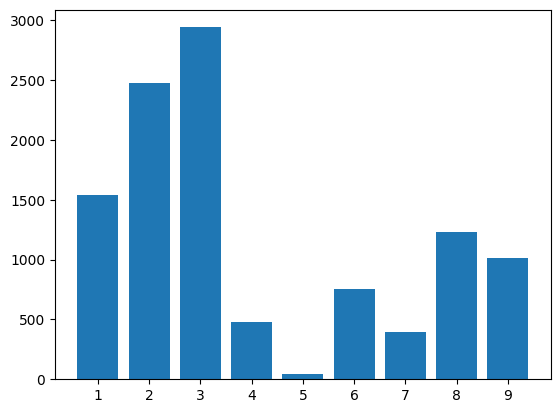

In [7]:
## Data visualisation of the Full Dataset 
#I want to count the occurences of each type in the full dataset to compare to my (extremely small and not perfect) subset

occurences = {
    "1":0,
    "2":0,
    "3":0,
    "4":0,
    "5":0,
    "6":0,
    "7":0,
    "8":0,
    "9":0
}



    
#For occurences of full list   
for i in range(1, filenames.index.stop):
    stringClass = str(filenames.loc[i,"Class"])
    occurences[stringClass] = occurences[stringClass] + 1
    #print(stringClass)
    print("Class: " + str(stringClass) + " - Occurences: " + str(occurences[stringClass]))
   
    
plt.bar(range(len(occurences)), list(occurences.values()), align="center")
plt.xticks(range(len(occurences)), list(occurences.keys()))
plt.show()

# Data Visualisation of the subset dataset

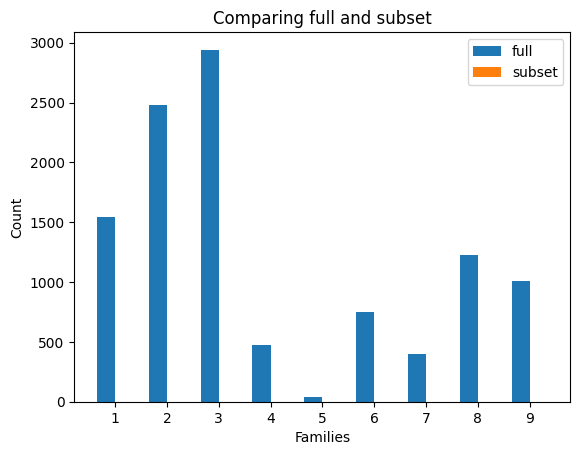

In [8]:
## Data visualisation Test - I'm going to break these down in to proportions
            
#I want to count the occurences of each type in this dataset to see how well rounded my (extremely small and not perfect) subset is
subsetOccurences = {
    "1":0,
    "2":0,
    "3":0,
    "4":0,
    "5":0,
    "6":0,
    "7":0,
    "8":0,
    "9":0
}

for i in range(1, len(subsetOccurences)):
    subsetOccurences[str(i)] = eachClassOccurences.count(i)

#plt.bar(range(len(occurences)), list(occurences.values()), align="center")
#plt.xticks(range(len(occurences)), list(occurences.keys()))
#plt.show()



## This compares the full and sample datasets to provide insight into how representative one is of the other
index = np.arange(9)
barWidth = 0.35

fig, ax = plt.subplots()
full = ax.bar(index, occurences.values(), barWidth, label = "full")
subset = ax.bar(index+barWidth, subsetOccurences.values(), barWidth, label = "subset")

ax.set_xlabel("Families")
ax.set_ylabel("Count")
ax.set_title("Comparing full and subset")
ax.set_xticks(index + barWidth/2)
ax.set_xticklabels(subsetOccurences.keys())
ax.legend()

plt.show()

# NN Start

In [9]:
df2 = pd.read_csv('/home/eddy/machine-learning/data/dataframe.csv', index_col=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df2)
#draft here
pass 
#class NeuralNetFam1(nn.module):
    #feeding the initialisation function the relevant data (raw Hex from files and raw ASM from files)
    #This could be done by feeding a DF where there is a column for every present instruction and a row for each malware in the relevant family
    #def __init__(self, rawHex, fileContentsRaw):  
        

                          JL    REP    ROR     SAR     DEC    NEG  RCR  \
0BEsCP7NAUy8XmkenHWG     1.0    1.0    1.0     1.0     2.0    2.0  2.0   
0PGoOfXAjVDBytkRH4Um     0.0    0.0    0.0     0.0     2.0    0.0  0.0   
0cGWK6VvCkm7O2AxDjtw     0.0    0.0    0.0     0.0     1.0    0.0  0.0   
0QK142N5HoBntC7RydAh     4.0    0.0    3.0    28.0    44.0    0.0  1.0   
0Fu9oETtMW4zlg1ZrUy6     0.0    0.0    0.0     0.0     1.0    0.0  0.0   
0KZFcsOYR4MdPJf6VvGS     3.0    1.0    0.0     0.0     0.0   14.0  0.0   
0nxrvcZJUBNGM8Vg4SRf     4.0    1.0    0.0    19.0     8.0    0.0  0.0   
0OQ9MEykugoYZJrnj64d     0.0    0.0    0.0     0.0     3.0    0.0  0.0   
0aKlH1MRxLmv34QGhEJP     0.0    0.0    0.0     0.0    31.0    0.0  0.0   
0aVxkvmflEizUBG2rMT4     4.0    0.0    1.0    19.0     5.0    0.0  0.0   
0pQ123lKqiLJtFTwjBfG    25.0    5.0    8.0    17.0    39.0    4.0  2.0   
0P6tEopzr2mIhkuOKiCD    73.0   17.0    0.0    28.0   108.0    5.0  0.0   
0giIqhw6e4mrHYzKFl8T     4.0    1.0   